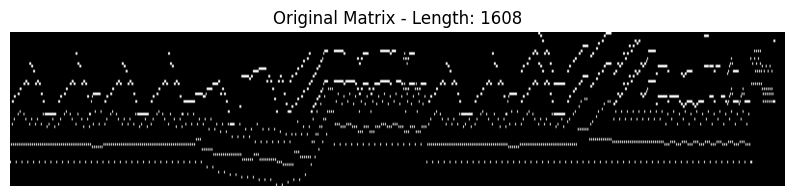

Scale factor (Block Reduce): 12.5625


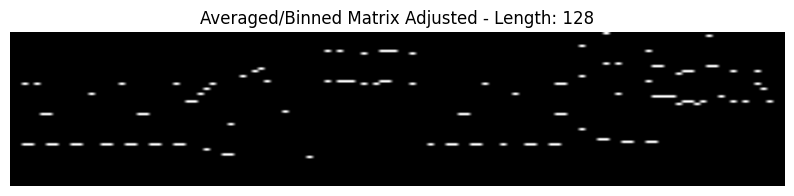

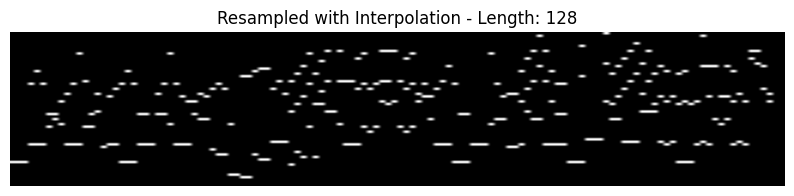

Scale factor (Block Reduce): 12.5625


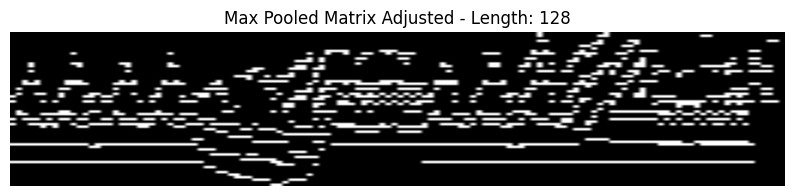

Scale factor (Block Reduce): 12.5625


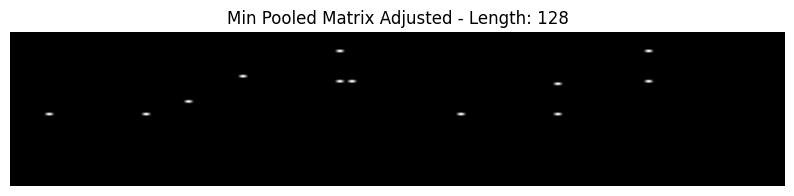

In [1]:
import numpy as np
from scipy.ndimage import zoom
from skimage.measure import block_reduce
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt

path = 'C:\\Users\\egorp\\Nextcloud\\code\\public_repos\\binary_symbolic_representations\\chopin.npy'
binary_matrix = np.load(path)

def plot_matrix(matrix, title):
    plt.figure(figsize=(10, 2))
    plt.title(f"{title} - Length: {matrix.shape[1]}")
    plt.imshow(matrix, aspect='auto', cmap='gray', origin='lower')
    plt.axis('off')
    plt.show()

def save_matrix(matrix, file_path):
    np.save(file_path, matrix)

def resize_length_only(matrix, target_length):
    current_length = matrix.shape[1]
    # This is a zoom factor, which will be >1 for upscaling and <1 for downscaling
    zoom_factor = target_length / current_length
    resized_matrix = zoom(matrix, (1, zoom_factor), order=0)
    # Correctly print the scale factor as the ratio of current to target lengths
    # print(f"Scale factor (Resize): {current_length/target_length}")
    return resized_matrix

def block_reduce_handling(matrix, target_length, func, pooling_before_resizing=True):
    current_length = matrix.shape[1]
    
    # Function to apply pooling
    def apply_pooling(matrix, block_size_length, func):
        return block_reduce(matrix, block_size=(1, block_size_length), func=func)

    if pooling_before_resizing:
        if target_length < current_length:
            scale_factor = current_length / target_length
            block_size_length = np.round(scale_factor).astype(int)
            reduced_matrix = apply_pooling(matrix, block_size_length, func)
            # Check if additional resizing is needed
            if reduced_matrix.shape[1] != target_length:
                reduced_matrix = resize_length_only(reduced_matrix, target_length)
        else:
            # Upscaling directly since pooling doesn't apply well to upscaling
            reduced_matrix = resize_length_only(matrix, target_length)
    else:
        # Resize first if pooling is to be done after
        resized_matrix = resize_length_only(matrix, target_length)
        if target_length < current_length:
            # Calculate new scale factor after resizing because the length might have changed
            new_scale_factor = resized_matrix.shape[1] / target_length
            block_size_length = np.round(new_scale_factor).astype(int)
            reduced_matrix = apply_pooling(resized_matrix, block_size_length, func)
        else:
            # If upscaling, there's no pooling to apply after resizing
            reduced_matrix = resized_matrix

    print(f"Scale factor (Block Reduce): {current_length/target_length}")
    return reduced_matrix


target_length = 128
pooling_before_resizing=True

# Original matrix
plot_matrix(binary_matrix, "Original Matrix")
save_matrix(binary_matrix, "original_matrix.npy")

# Averaging / Binning
averaged_matrix = block_reduce_handling(binary_matrix, target_length, np.mean)
averaged_matrix_binarized = Binarizer(threshold=0.5).fit_transform(averaged_matrix)
plot_matrix(averaged_matrix_binarized, "Averaged/Binned Matrix Adjusted")
save_matrix(averaged_matrix_binarized, "averaged_binned_matrix_adjusted.npy")

# Resampling with Interpolation
interpolated_matrix = resize_length_only(binary_matrix, target_length)
interpolated_matrix_binarized = Binarizer(threshold=0.5).fit_transform(interpolated_matrix)
plot_matrix(interpolated_matrix_binarized, "Resampled with Interpolation")
save_matrix(interpolated_matrix_binarized, "resampled_interpolation.npy")

# Max Pooling
max_pooled_matrix = block_reduce_handling(binary_matrix, target_length, np.max, pooling_before_resizing)
max_pooled_matrix_binarized = Binarizer(threshold=0.5).fit_transform(max_pooled_matrix)
plot_matrix(max_pooled_matrix_binarized, "Max Pooled Matrix Adjusted")
save_matrix(max_pooled_matrix_binarized, "max_pooled_matrix_adjusted.npy")

# Min Pooling
min_pooled_matrix = block_reduce_handling(binary_matrix, target_length, np.min, pooling_before_resizing)
min_pooled_matrix_binarized = Binarizer(threshold=0.5).fit_transform(min_pooled_matrix)
plot_matrix(min_pooled_matrix_binarized, "Min Pooled Matrix Adjusted")
save_matrix(min_pooled_matrix_binarized, "min_pooled_matrix_adjusted.npy")


In [3]:
import numpy as np
import mido
from mido import MidiFile, MidiTrack, Message, second2tick
import ipywidgets as widgets
from ipywidgets import Output
from IPython.display import display, clear_output
import pygame
import time

binary_matrix = averaged_matrix_binarized

def generate_midi(
    midi_matrix, 
    output_filename='output_test.mid', 
    smallest_duration_ms=400, 
    lowest_midi_pitch=51,
    tempo=500000,  # Default tempo (microseconds per beat)
    velocity=64     # Default velocity for note_on and note_off
):
    """
    Generates a MIDI file from a binary matrix.
    """
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo))
    ticks_per_smallest_duration = second2tick(
        smallest_duration_ms / 1000, 
        mid.ticks_per_beat, 
        tempo
    )
    note_states = np.zeros(midi_matrix.shape[0], dtype=int)
    time_since_last_event = 0

    for col_index in range(midi_matrix.shape[1]):
        for row_index, note_state in enumerate(midi_matrix[:, col_index]):
            note = lowest_midi_pitch + row_index
            if note_state != note_states[row_index]:
                note_states[row_index] = note_state
                msg_type = 'note_on' if note_state == 1 else 'note_off'
                track.append(Message(
                    msg_type, 
                    note=note, 
                    velocity=velocity, 
                    time=int(time_since_last_event)
                ))
                time_since_last_event = 0
        time_since_last_event += ticks_per_smallest_duration

    for row_index, state in enumerate(note_states):
        if state == 1:
            note = lowest_midi_pitch + row_index
            track.append(Message('note_off', note=note, velocity=velocity, time=int(time_since_last_event)))

    mid.save(output_filename)
    print(f'MIDI file saved successfully: {output_filename}')

generate_midi(
    midi_matrix=binary_matrix, 
    output_filename='output_test1.mid', 
    smallest_duration_ms=250, 
    lowest_midi_pitch=51
)

pygame.init()
pygame.mixer.init()

is_playing = False
midi_file_location = "output_test1.mid"

midi_player = Output()

play_button = widgets.Button(description='Play MIDI', button_style='success')
stop_button = widgets.Button(description='Stop MIDI', button_style='danger')
stop_button.disabled = True

def play_midi(b):
    global is_playing
    with midi_player:
        clear_output(wait=True)
        try:
            pygame.mixer.music.load(midi_file_location)
            pygame.mixer.music.play()
            is_playing = True
            play_button.disabled = True
            stop_button.disabled = False
            print(f'Playing {midi_file_location}...')
        except Exception as e:
            print(f'Error playing MIDI file: {e}')

def stop_midi(b):
    global is_playing
    if is_playing:
        pygame.mixer.music.stop()
        is_playing = False
        play_button.disabled = False
        stop_button.disabled = True
        print('Playback stopped.')

play_button.on_click(play_midi)
stop_button.on_click(stop_midi)

button_box = widgets.HBox([play_button, stop_button])
display(button_box)
display(midi_player)


MIDI file saved successfully: output_test1.mid


Output()